In [1]:
%matplotlib inline
from numpy import *
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.stats import mad_std, SigmaClip, sigma_clipped_stats
from photutils.detection import DAOStarFinder
from platform import python_version
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import *
from astropy.visualization import SqrtStretch
from photutils import *
from astropy.modeling.models import Moffat1D
from scipy.signal import peak_widths

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u

# import kosmos... if we do it right this should be the only other thing to import someday!
import sys

sys.path.insert(0, '/Users/josue/kosmos/')
import warnings
warnings.filterwarnings('ignore')


In [2]:
import kosmos
DISPLAY = True

In [3]:
kosmos.__version__

'0.1'

In [4]:
#checks the filter
def what_filter(k):
    j = []
    for i in k:
        hdu_list = fits.open(i)
        a = hdu_list[0].header['FILTER']
        j.append(a)
    print("Filters:")
    return j

# Creats a directory array
def dir_array(j):
    i = pd.read_table(dir + j, names=['impath'])
    k = dir + i['impath'].values
    #print(k)
    return k

## 1. Master Bias

In [5]:
dir = 'C:/Users/josue/Work-space/data/07082022/'
biasfiles_i = pd.read_table(dir + 'bias_08.txt', names=['impath'])
biasfiles = dir + biasfiles_i['impath'].values
biasfiles

array(['C:/Users/josue/Work-space/data/07082022/bias_001.fits',
       'C:/Users/josue/Work-space/data/07082022/bias_002.fits',
       'C:/Users/josue/Work-space/data/07082022/bias_003.fits',
       'C:/Users/josue/Work-space/data/07082022/bias_004.fits',
       'C:/Users/josue/Work-space/data/07082022/bias_005.fits',
       'C:/Users/josue/Work-space/data/07082022/bias_006.fits',
       'C:/Users/josue/Work-space/data/07082022/bias_007.fits'],
      dtype=object)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512, 512)


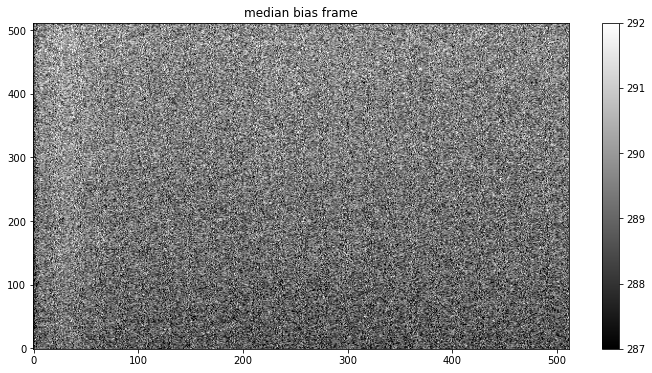

In [6]:
bias = kosmos.biascombine(biasfiles) 
print(bias.shape)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(bias, origin='lower', aspect='auto', cmap=plt.cm.gray)
    plt.title('median bias frame')
    plt.clim(np.percentile(bias, (5, 98)))
    cb = plt.colorbar()

## 2. Master Flats (compareing dome flats to sky flats)

In [7]:
# dome flats
dome_flats_B = dir_array('dome_flats_B.txt')
dome_flats_r = dir_array('dome_flats_r.txt')
dome_flats_V = dir_array('dome_flats_V.txt')
# sky flats
sky_flats_B = dir_array('sky_flats_B.txt')
sky_flats_r = dir_array('sky_flats_r.txt')
sky_flats_V = dir_array('sky_flats_V.txt')
flats_r_15s = dir_array('Flat_r_15s.txt')
# confirming filter
#what_filter(dome_flats_B)
what_filter(biasfiles)

Filters:


['B', 'B', 'B', 'B', 'B', 'B', 'B']

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passe

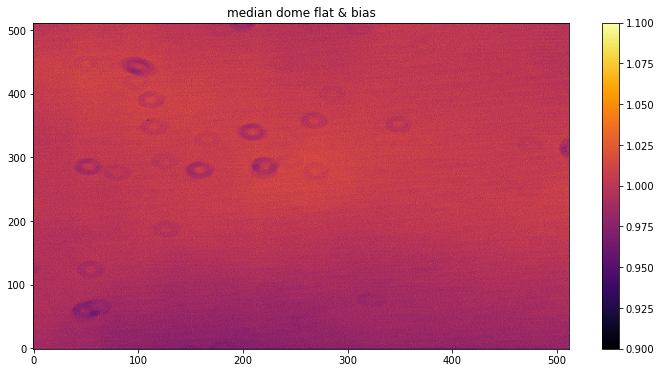

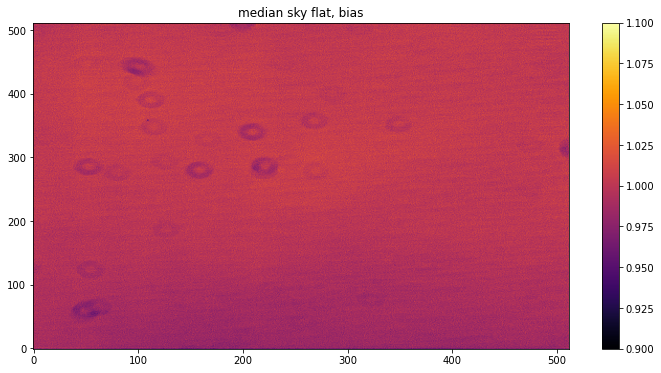

In [8]:
# B filter dome master flat
flat_B, ilum_B = kosmos.flatcombine(dome_flats_B, bias=bias, trim=None)

print(ilum_B.shape) # this is the indicies that are illuminated
print(flat_B.shape)
print(flat_B.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# B filter sky master flat
sky_flat_B, sky_ilum_B = kosmos.flatcombine(sky_flats_B, bias=bias, trim=None)

print(sky_ilum_B.shape) # this is the indicies that are illuminated
print(sky_flat_B.shape)
print(sky_flat_B.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(sky_flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passe

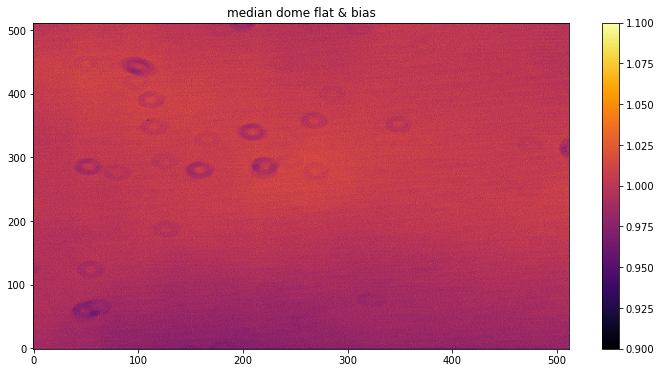

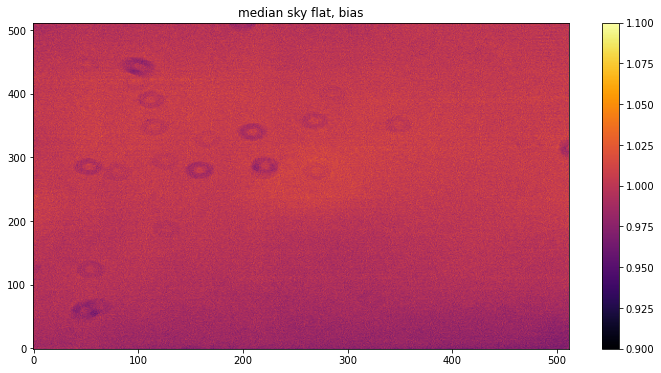

In [9]:
# r filter dome master flat
flat_r, ilum_r = kosmos.flatcombine(dome_flats_r, bias=bias, trim=None)

print(ilum_r.shape) # this is the indicies that are illuminated
print(flat_r.shape)
print(flat_r.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# r filter sky master flat
sky_flat_r, sky_ilum_r = kosmos.flatcombine(sky_flats_r, bias=bias, trim=None)

print(sky_ilum_r.shape) # this is the indicies that are illuminated
print(sky_flat_r.shape)
print(sky_flat_r.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(sky_flat_r, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passe

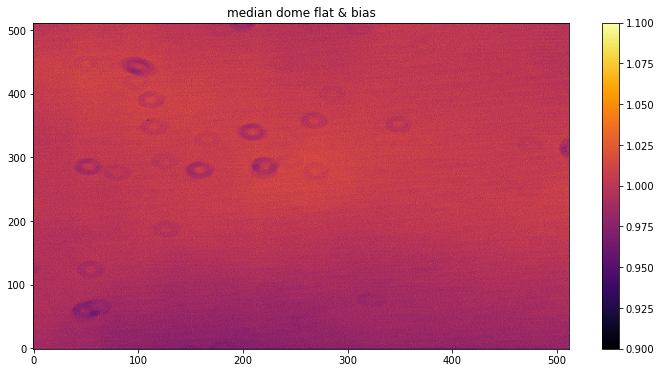

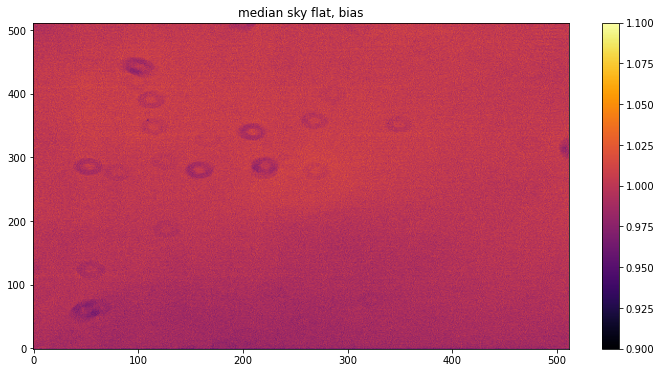

In [10]:
# V filter dome master flat
flat_V, ilum_V = kosmos.flatcombine(dome_flats_V, bias=bias, trim=None)

print(ilum_V.shape) # this is the indicies that are illuminated
print(flat_V.shape)
print(flat_V.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# V filter sky master flat
sky_flat_V, sky_ilum_V = kosmos.flatcombine(sky_flats_V, bias=bias, trim=None)

print(sky_ilum_V.shape) # this is the indicies that are illuminated
print(sky_flat_V.shape)
print(sky_flat_V.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(sky_flat_V, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

In [11]:
sky_flat_V

CCDData([[0.94133715, 0.93469925, 0.92465508, ..., 0.92692916, 0.92595162,
          0.91823972],
         [1.06686263, 1.0643052 , 1.06923372, ..., 1.07392997, 1.06743375,
          1.06008603],
         [0.95415977, 0.96522484, 0.96261678, ..., 0.95396361, 0.96927288,
          0.96236762],
         ...,
         [0.99081698, 0.98729856, 0.98612801, ..., 1.00346591, 1.01218462,
          0.99996799],
         [0.9917467 , 0.99215091, 0.99035151, ..., 1.00184564, 0.99336089,
          0.98541324],
         [0.99659823, 0.98864814, 0.99453312, ..., 0.99945069, 1.00133704,
          1.0077387 ]], unit='adu / s')

In [12]:
flat_V

CCDData([[0.94939882, 0.94523224, 0.93317588, ..., 0.91489798, 0.93043286,
          0.91953036],
         [1.00871126, 1.02141482, 1.02171468, ..., 1.042925  , 1.04430598,
          1.04339947],
         [0.9631336 , 0.96668259, 0.95859084, ..., 0.94892119, 0.95702462,
          0.9593715 ],
         ...,
         [0.99279442, 0.9918814 , 0.9927376 , ..., 0.99240747, 1.00082007,
          0.99536298],
         [0.99931608, 0.99668352, 0.99412877, ..., 0.99838553, 0.99337145,
          0.98160241],
         [0.99328693, 0.9910235 , 0.9927376 , ..., 0.99333219, 0.99479123,
          0.99687553]], unit='adu / s')

In [13]:
n = sky_flat_V.data
b = flat_V.data

In [14]:
g = n/b
the_ultimate_flat = CCDData(g, unit="adu / s")

In [15]:
the_ultimate_flat

CCDData([[0.99150866, 0.98885672, 0.99086903, ..., 1.0131503 , 0.9951837 ,
          0.99859642],
         [1.05764918, 1.04199115, 1.04650911, ..., 1.02972886, 1.02214654,
          1.0159925 ],
         [0.99068268, 0.998492  , 1.00419985, ..., 1.00531384, 1.01279827,
          1.00312301],
         ...,
         [0.99800821, 0.99537965, 0.99334206, ..., 1.01114304, 1.01135523,
          1.00462646],
         [0.99242544, 0.99545231, 0.99620043, ..., 1.0034657 , 0.99998936,
          1.00388225],
         [1.00333368, 0.99760312, 1.00180866, ..., 1.00615957, 1.00658008,
          1.01089721]], unit='adu / s')

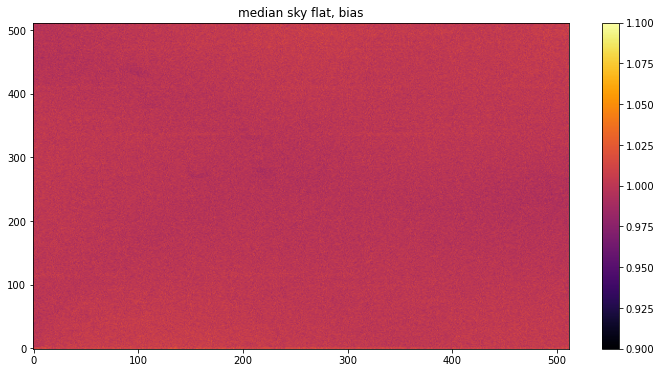

In [16]:
if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(the_ultimate_flat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median sky flat, bias')
    cb = plt.colorbar()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512, 512)
adu / s


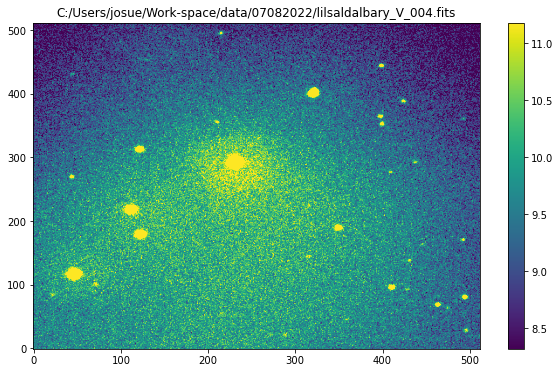

In [17]:
# NGC 6229 in the r filter
sci = dir + 'lilsaldalbary_V_004.fits' 
sciimg = kosmos.proc(sci, bias=bias, ilum=None, flat=the_ultimate_flat, trim=None)

print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(10,6))
    plt.imshow(sciimg, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(sci)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512, 512)
adu / s


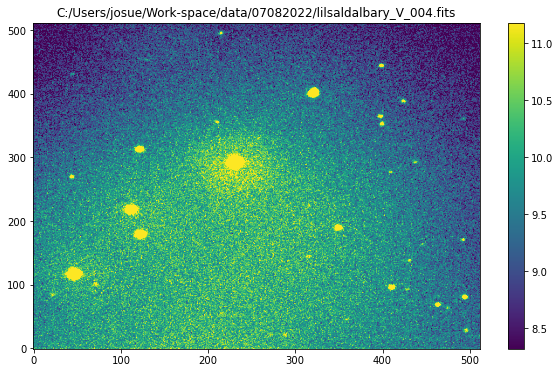

In [18]:
# NGC 6229 in the r filter
sci = dir + 'lilsaldalbary_V_004.fits' 
sciimg_1 = kosmos.proc(sci, bias=bias, ilum=None, flat=flat_V, trim=None)

print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(10,6))
    plt.imshow(sciimg_1, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(sci)

In [19]:
img_1 = np.median(sciimg)
img_1

9.573241058943182

In [20]:
img_2 = np.median(sciimg_1)
img_2

9.597454960262722

#### When looking at the illumination correction sciimg and comparing it to the non illumination correction sciimag we see a small change in the mean value. the illumination corrected image has a difference of 0.02. From this we can conclude that the illumination correced image has no significant impact.

In [21]:
flats_r_15s = dir_array('Flat_r_15s.txt')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512,)
(512, 512)
adu / s


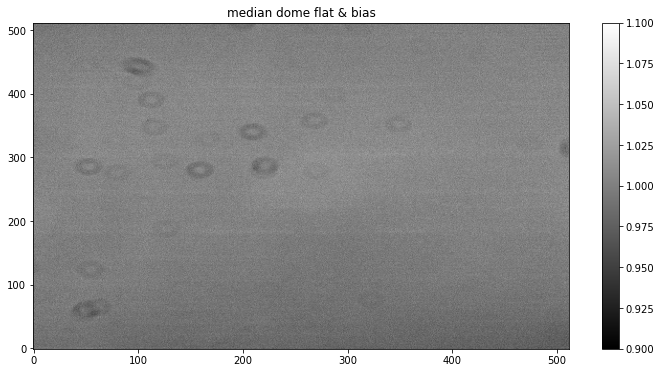

In [22]:
flat_B_1, ilum_B_1 = kosmos.flatcombine(flats_r_15s, bias=bias, trim=None)

print(ilum_B_1.shape) # this is the indicies that are illuminated
print(flat_B_1.shape)
print(flat_B_1.unit)

if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.imshow(flat_B_1, origin='lower', aspect='auto', cmap='gray')
    plt.clim(.9,1.1)
    plt.title('median dome flat & bias')
    cb = plt.colorbar()

# Lin Test

In [23]:
lin_test_flats = dir_array('linTest.txt')
# lin_test_flats

In [24]:
# takes the exposure time from the header and puts them in to an array
# then takes the mean count of all flats and put them in an array as well
exp_time = []
mean_count = []
for i in lin_test_flats:
    hdu_list = fits.open(i)
    k = hdu_list[0].data
    a = hdu_list[0].header['exptime']
    exp_time.append(a)
    mean = np.mean(k)
    mean_count.append(mean)

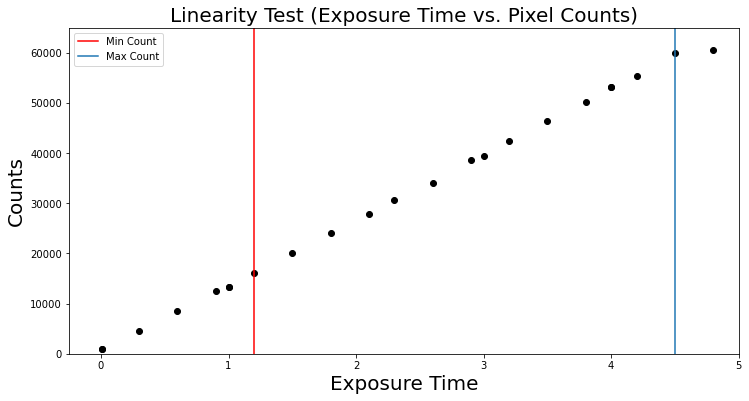

In [25]:
y = np.linspace(-5, 650000)
x = np.linspace(1.2,1.2)
x_2 = np.linspace(4.5,4.5)
if DISPLAY:
    plt.figure(figsize=(12,6))
    plt.scatter(exp_time, mean_count, c = 'k')
    plt.title('Linearity Test (Exposure Time vs. Pixel Counts)', fontsize = 20)
    plt.plot(x, y, 'r', label='Min Count')
    plt.plot(x_2, y, label = 'Max Count')
    plt.xlim(-0.25, 5)
    plt.ylim(0, 65000)
    plt.xlabel("Exposure Time", fontsize = 20)
    plt.ylabel("Counts", fontsize = 20)
    plt.legend()
    

### Evora

In [26]:
# gain = ((F_1 + F_2) - (B_1 + B_2)) / sig(F1-F2)**2 - sig(B1-B2)
dome_flats_B

array(['C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_001.fits',
       'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_002.fits',
       'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_003.fits',
       'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_004.fits',
       'C:/Users/josue/Work-space/data/07082022/domeflat_1sec_3_005.fits'],
      dtype=object)

In [27]:
# B filter flats
flat_1 = sky_flats_B[0]
flat_2 = sky_flats_B[1]

# B bias 
bias_1 = biasfiles[0]
bias_2 = biasfiles[1]

In [28]:
def get_data(i):
    hdu_list = fits.open(i)
    k = hdu_list[0].data
    return k

In [29]:
flat_1_data = get_data(flat_1)
flat_2_data = get_data(flat_2)

In [30]:
bias_1_data = get_data(bias_1)
bias_2_data = get_data(bias_2)
np.mean(bias_2_data)

289.603328704834

In [31]:
mean_flats = np.mean(flat_1_data) + np.mean(flat_2_data)
mean_bias = np.mean(bias_1_data) + np.mean(bias_2_data)
print(mean_flats)
print(mean_bias)

53714.04751205444
580.9252319335938


In [32]:
f_diff = flat_1_data - flat_2_data
b_diff = bias_1_data - bias_2_data
np.mean(b_diff)

17677.218574523926

In [33]:
top = (mean_flats - mean_bias)
top

53133.12228012085

In [34]:
f_diff_std = np.std(f_diff)
b_diff_std = np.std(b_diff)
print(f_diff_std)
print(b_diff_std)

229.98186744325096
29082.64469818175


In [35]:
bottom = -(f_diff_std**2) + (b_diff_std**2)
bottom

845747330.9813263

In [36]:
gain = top/bottom
gain

6.282387225327703e-05

In [37]:
r_Noise = (gain * b_diff_std) / np.sqrt(2)

In [38]:
r_Noise

1.2919437374367344

 we had cooling issues on the second day. This can be the reason why my bias std are weird

## Extinction

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(512, 512)
adu / s


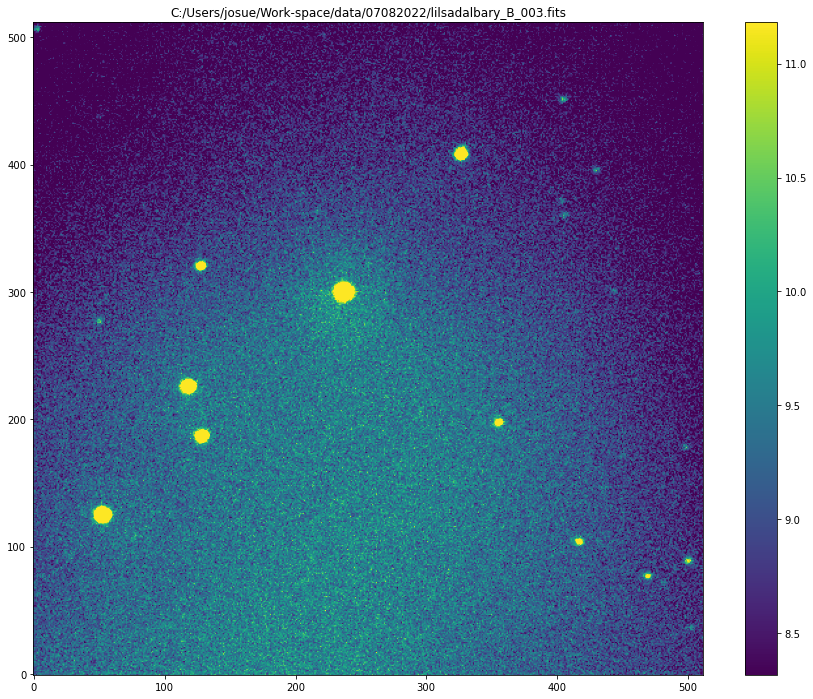

In [39]:
# BD+234616 in the B filter
sci = dir + 'lilsadalbary_B_003.fits' 
sciimg_1 = kosmos.proc(sci, bias=bias, ilum=None, flat=flat_B, trim=None)

print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(15,12))
    plt.imshow(sciimg_1, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(sci)

## Signal to Noise Ratio

FWHM = 2.18


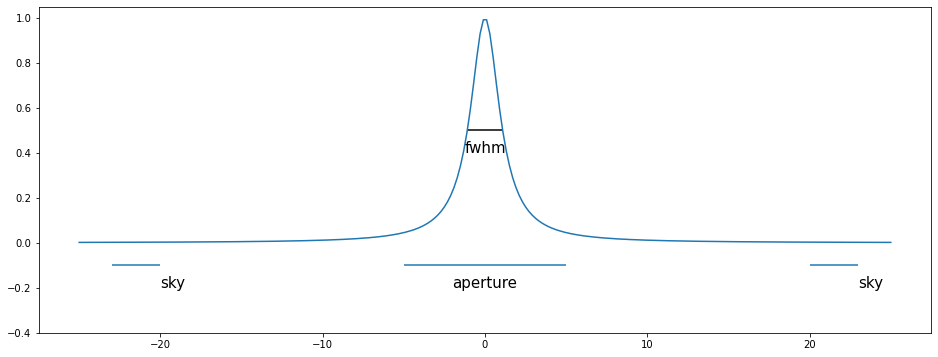

In [260]:
# Plot a 1-D model PSF
flux = 1
gamma = 1.09 # *Half* width at half max
alpha = 1  # power index (shape)
PSF = Moffat1D(flux, 0, gamma, alpha)
plt.figure(figsize=(16,6)) # make the plot w i d e
ymin, ymax = plt.ylim(-0.4,1.05) # make some space for labels
X = np.linspace(-25,25,250)
plt.plot(X, PSF(X))

# Label the fwhm
fwhm = PSF.fwhm
FWHM = 2.18
print("FWHM =", fwhm)
plt.hlines(0.5, 0-fwhm/2., 0+fwhm/2, color="k")
txt = plt.annotate("fwhm", (0, 0.4), size=15, ha="center")

# Show where a circular aperture would go
aperture_radius = 5
plt.hlines(-0.1, -aperture_radius, aperture_radius)
txt = plt.annotate("aperture", (0, -0.2), size=15, ha="center")

# Show sky annulus where background light is measured
annulus_r_in = -20
annulus_r_out = -23
plt.hlines(-0.1, -annulus_r_in, -annulus_r_out)
txt = plt.annotate("sky", (-annulus_r_out, -0.2), size=15)
plt.hlines(-0.1, annulus_r_in, annulus_r_out)
txt = plt.annotate("sky", (annulus_r_in, -0.2), size=15)

In [127]:
mean, median, std = sigma_clipped_stats(sciimg_1, sigma=3.0)

In [128]:
kill_me = sciimg_1.data
sciimg_1_data = np.ma.getdata(kill_me)

In [129]:
dao = DAOStarFinder(fwhm=2.18, threshold=117.*std)
sour = dao(sciimg_1_data - median)

In [130]:
print(sour)

 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  53.52046837582825 ... 1.0108922223175503 -0.011762137869980913
  2 237.78258761275896 ... 1.7942163790320045   -0.6346870423567734


In [224]:
dao = DAOStarFinder(fwhm=2.18, threshold=117.*std)
sources = dao(sciimg_1_data - median)
print(sources)
positions = []
for i, j in zip(sources['xcentroid'], sources['ycentroid']):
        positions.append((i,j));
apertures = CircularAperture(positions, r=4.36)
norm = ImageNormalize(stretch=SqrtStretch())
# if DISPLAY:
#     plt.figure(figsize=(20,20))
#     plt.imshow(sciimg_1_data, cmap='inferno', origin='lower', norm=norm)
#     apertures.plot(color='blue', lw=1.5, alpha=1);

 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  53.52046837582825 ... 1.0108922223175503 -0.011762137869980913
  2 237.78258761275896 ... 1.7942163790320045   -0.6346870423567734


In [225]:
phot = aperture_photometry(sciimg_1, apertures)

for col in phot.colnames:phot[col].info.format = '%.8g'
source = phot['aperture_sum']
print(phot)

 id  xcenter   ycenter  aperture_sum
       pix       pix      adu / s   
--- --------- --------- ------------
  1 53.520468 124.92254    3395.5132
  2 237.78259 299.93559     5695.478


<Quantity 2840.51438252 adu / s>

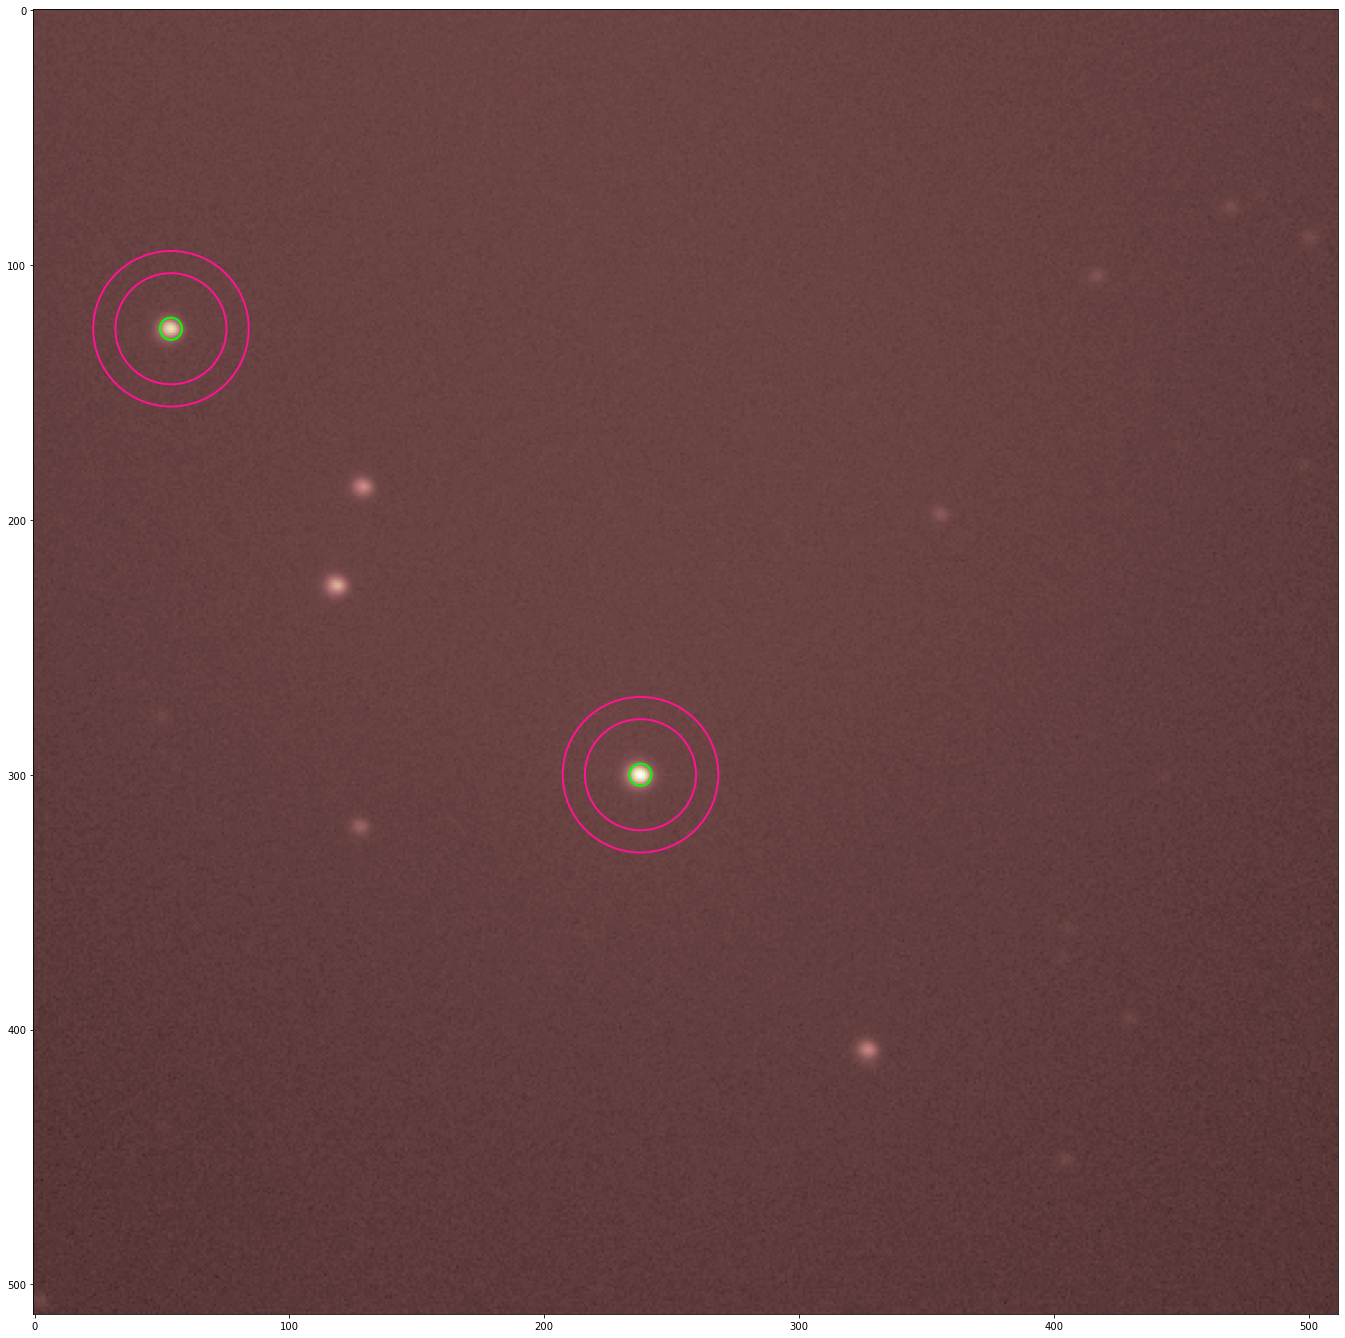

In [226]:
annulus = CircularAnnulus(positions,r_in = 21.8,r_out = 30.52)
plt.figure(figsize=(24,24))
annulus.plot(color='deeppink',linewidth=2)
apertures.plot(color='lime',linewidth=2)
plt.imshow(sciimg_1,norm=norm,cmap='pink');
total_sky = aperture_photometry(sciimg_1,annulus)['aperture_sum']
avg_sky = total_sky / annulus.area
sky = avg_sky * apertures.area
fluxes = source - sky
fluxes[0]

In [227]:
extco = dir_array('extco.txt')
y = []
for i in extco:
    hdu_list = fits.open(i)
    a = hdu_list[0].header['airmass']
    y.append(a)


In [261]:
def flux(path):
    sciimg_1 = kosmos.proc(path, bias=bias, ilum=None, flat=sky_flat_B, trim=None)
    mean, median, std = sigma_clipped_stats(sciimg_1, sigma=3.0)
    kill_me = sciimg_1.data
    sciimg_1_data = np.ma.getdata(kill_me)
    dao = DAOStarFinder(fwhm=2.18, threshold=117.*std)
    sources = dao(sciimg_1_data - median)
    positions = []
    for i, j in zip(sources['xcentroid'], sources['ycentroid']):
            positions.append((i,j));
    apertures = CircularAperture(positions, r=5)
    norm = ImageNormalize(stretch=SqrtStretch())
    annulus = CircularAnnulus(positions,r_in = 21.8,r_out = 30.52)
    
    
    total_sky = aperture_photometry(sciimg_1,annulus)['aperture_sum']
    avg_sky = total_sky / annulus.area
    sky = avg_sky * apertures.area
    fluxes = source - sky
    return fluxes[0]

In [262]:
true_flux = []
for i in extco:
    j = flux(i)
    k = j.value
    true_flux.append(k)
    
    

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [263]:
true_flux

[2333.1280407165714,
 2531.123999882728,
 2665.6344180668107,
 2748.6750065002147,
 2378.91862187967,
 2694.8868174210293,
 2620.2294407493373,
 1867.7928203540698]

In [264]:
exp_time = []
for i in extco:
    hdu_list = fits.open(i)
    a = hdu_list[0].header['exptime']
    exp_time.append(a)

In [330]:
flux_array = np.asarray(true_flux)
exptime_array = np.asarray(exp_time)

In [331]:
# Can also do everything in fewer lines and/or make a function, such as:
def makemag(flux,exptime,C):
    m = C - 2.5 * np.log(np.abs(flux / exptime))
    return m
mags = makemag(flux_array, exptime_array, 10)
print(mags)
print(y)

[ 0.84844852  0.64481453  0.515368    0.43867576 -0.9330098   0.48808269
  0.55831849  1.40457965]
[2.251631596453429, 1.849002925433075, 1.615972923989696, 1.473992536131771, 2.135816774110221, 1.348920539084355, 1.247314325951935, 1.199461299985704]


In [329]:
# uses the best mags and best airmass
best_mags = np.delete(mags, (4,7,6,5))
best_airmass = np.delete(y, (4,7,5,6))
print(best_airmass)
print(best_mags)

[2.2516316  1.84900293 1.61597292 1.47399254]
[0.84844852 0.64481453 0.515368   0.43867576]


In [328]:
# function to calculate slope
def slopee(x1,y1,x2,y2):
    x = (y2 - y1) / (x2 - x1)
    return x

Extinction = 0.5269446782790451


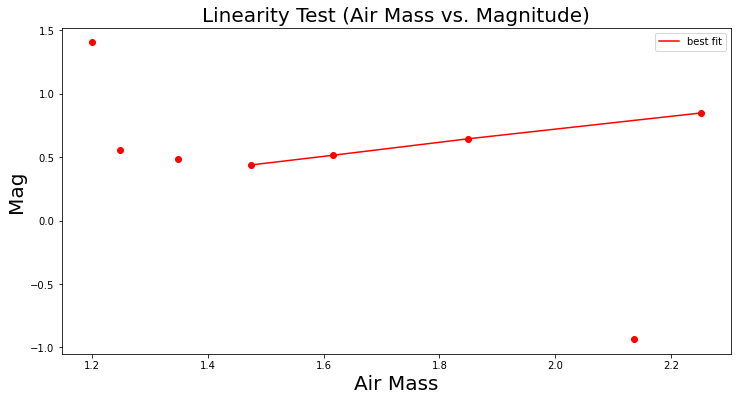

In [327]:
x_1 = best_airmass[0]
y_1 = best_mags[0]
x_2 = best_airmass[3]
y_2 = best_mags[3] 

ext = slopee(x_1,y_1,x_2,y_2)

if DISPLAY:
    plt.figure(figsize=(12,6))
    # plt.scatter(exp_time, mean_count, c = 'k')
    plt.title('Linearity Test (Air Mass vs. Magnitude)', fontsize = 20)
    # plots the most linear points
    plt.plot(best_airmass, best_mags, c='r', label='best fit')
    plt.scatter(y, mags, c='r')
    slope = np.polyfit(np.log(best_airmass), np.log(best_mags), 1)
    plt.xlabel("Air Mass", fontsize = 20)
    plt.ylabel("Mag", fontsize = 20)
    plt.legend()
    print(f"Extinction = {ext}")